In [1]:
import os
import sys
sys.path.append('../src')

# Usual Imports
import numpy as np
import pandas as pd  

# Imports Specific to NeuOsc Modules
import oscprob3nu
import hamiltonians3nu
from globaldefs import *

# Matplotlib
import matplotlib
try:
    matplotlib.rcParams['text.usetex'] = True
    # set the grids in the background
    matplotlib.rcParams['axes.axisbelow'] = True
    # Font size
    matplotlib.rcParams.update({'font.size': 12})
except:
    pass
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

# Bokeh Package
from bokeh.models import Label
from bokeh.io import export_png
from bokeh.plotting import figure, output_file, show, gridplot
from bokeh.palettes import Category10
from bokeh.models import LinearAxis, Range1d, NumeralTickFormatter
output_file("line.html")
output_file("varea.html")
output_file("latex.html")

In [2]:
def trans_to_table(arr, shape):
    """Transform a tuple result into a
    table to print the results.
    
    Parameters:
    ----------
    arr: tuple
        Tuple of results
    shape: tuple
        Table output shape
    """
    np_arr = np.array(arr)
    rh_arr = np_arr.reshape(shape)
    ptable = pd.DataFrame(rh_arr, columns =['e', 'µ', 'T'])
    return ptable.rename({0: "e", 1: "µ", 2: "T"}, axis='index')

## Oscillations in Vacuum

#### Fixed Energies and Baselines

The following lines of codes compute the following:

 - Find the best-fit values of the mixing parameters and construct the Hamiltonian.
 - Compute the oscillation probabilities.

In [3]:
E = 1e9     # Neutrino Energy [eV]
L = 2e3     # Baseline        [km]

# Hamiltonian in the Vacuum non-normalized by the Energy E
H_vac = hamiltonians3nu.hamiltonian_3nu_vacuum_energy_independent(
            S12_NO_BF, S23_NO_BF,
            S13_NO_BF, DCP_NO_BF,
            D21_NO_BF, D31_NO_BF
        )

# Normalize by the Energy
H_vac_norm = 1/E * np.array(H_vac)

# Compute Oscillation Probabilities
Probs = oscprob3nu.probabilities_3nu(
            H_vac_norm,
            L * CONV_KM_TO_INV_EV
        )
OscProbs3 = trans_to_table(Probs, (3,3))
OscProbs3

,e,µ,T
e,0.970727,0.010286,0.018988
µ,0.009790,0.989311,0.000899
T,0.019484,0.000403,0.980114


#### Fixed Energies and varying Distances

In [4]:
# Define global Variables
lmin, lmax = 0, 1000   # [km]
emin, emax = 8, 9      # Log basis [eV]

In [5]:
def osc3neutrinos_baseline(L_min, L_max, nbpoints=1000, E=1e7):
    """Compute the Three neutrinos oscillations for varying
    values of distances.
    
    Parameters:
    ----------
    L_min: float
        Minimal value of the distance
    L_max: float
        Maximal value of the distance
    nbpoints: int, optional
        Number of points between L_min and L_max
    E: float, optional
        Value of the energy
    """
    L_vals = np.linspace(L_min, L_max, num=nbpoints)
    H_vac = hamiltonians3nu.hamiltonian_3nu_vacuum_energy_independent(
                S12_NO_BF, S23_NO_BF,
                S13_NO_BF, DCP_NO_BF,
                D21_NO_BF, D31_NO_BF
            )
    H_vac_norm = 1/E * np.array(H_vac)
    probs = [oscprob3nu.probabilities_3nu(
                H_vac_norm,
                l * CONV_KM_TO_INV_EV
            ) for l in L_vals]
    return L_vals, np.array(probs)

In [6]:
# Axes width
def axes_width(ax, lw=1):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
        
def plot_probs(folder, name, L_vals, probs, x_label, size=(7, 6.5), al=1,
              titl="Three Neutrinos Oscillations"):
    # Create folder if non-existing
    if not os.path.exists("plots/{}".format(folder)):
        os.mkdir("plots/{}".format(folder))
    else:
        pass
    # Compute Sums
    sums = probs[:,0] + probs[:,1] + probs[:,2]
    fig = plt.figure(figsize=size)
    gs  = gridspec.GridSpec(2, 1, height_ratios=[3.5, 1])

    ## Upper panel ##
    ax0 = plt.subplot(gs[0])
    # Pee
    ax0.plot(L_vals, probs[:,0], color=Category10[4][1], label=r"$P_{\nu_e \longleftarrow \nu_e}$")
    # Pem
    ax0.plot(L_vals, probs[:,1], color=Category10[4][0], label=r"$P_{\nu_\mu \longleftarrow \nu_e}$")
    # Pet
    ax0.plot(L_vals, probs[:,2], color=Category10[4][3], label=r"$P_{\nu_\tau \longleftarrow \nu_e}$")
    ax0.set_xscale('log')

    # Tick params
    axes_width(ax0, lw=1.15)
    ax0.tick_params(length=6, width=1.15, labelbottom=False)
    ax0.tick_params(which='minor', length=4, width=1)
    # y-axis
    ax0.yaxis.set_minor_locator(MultipleLocator(.05))
    ax0.grid(alpha=.45, linewidth=1.25)
    # Axes limit
    ax0.set_ylim(0, 1)
    ax0.set_xlim(L_vals[0] + 0.05, L_vals[-1])
    # Legend
    ax0.legend(title=titl,
               title_fontsize=15, fontsize=16, ncol=1, fancybox=True)
    ax0.set_ylabel(r"Probability $P_{\nu_\beta \longleftarrow \nu_\alpha}$", fontsize=16)

    # Lower panel
    ax1 = plt.subplot(gs[1])
    ax1.plot(L_vals, sums, color="green", linewidth=2.25)
    ax1.set_xscale('log')
    
    # Tick params
    axes_width(ax1, lw=1.15)
    ax1.tick_params(length=6, width=1.15)
    ax1.tick_params(which='minor', length=4, width=1)
    # y-axis
    ax1.yaxis.set_major_locator(MultipleLocator(.2))
    ax1.yaxis.set_minor_locator(MultipleLocator(.05))
    ax1.grid(alpha=.45, linewidth=1.25)
    # Axes limit
    ax1.set_ylim(0.75, 1.25)
    ax1.set_xlim(L_vals[0] + 0.05, L_vals[-1])
    ax1.set_ylabel("Sum", fontsize=16)
    # Label
    ax1.set_xlabel(x_label,fontsize=13)

    plt.tight_layout()
    plt.savefig('plots/{}/{}.pdf'.format(folder,name), dpi=175)

In [7]:
L_vals, prob_vac_dist = osc3neutrinos_baseline(0, 1000)

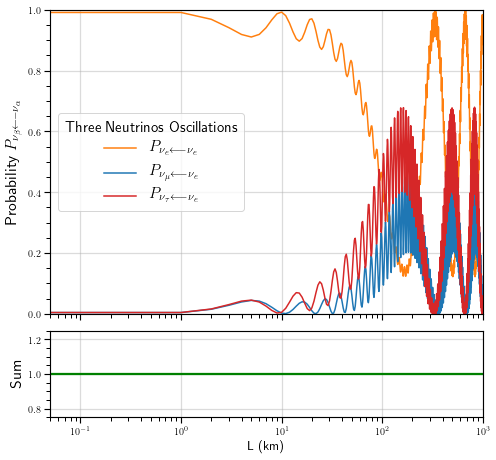

In [8]:
folder_name = "Osc3Neutrinos"
plot_name = "Osc3VacuumBaseline"
x_label = "L (km)"
plot_probs(folder_name, plot_name, L_vals, prob_vac_dist, x_label, size=(7, 6.5), al=1)

#### Varying Energies and Fixed Distances

In [9]:
def osc3neutrinos_energy(E_min, E_max, nbpoints=200, L=2e3):
    """Compute the Three neutrinos oscillations for varying
    values of energies.
    
    Parameters:
    ----------
    E_min: float
        Minimal value of the energy (eV)
    E_max: float
        Maximal value of the energy  (eV)
    nbpoints: int, optional
        Number of points between E_min and E_max
    L: float, optional
        Value of the distance
    """
    E_vals = np.logspace(E_min, E_max, num=nbpoints)
    H_vac = hamiltonians3nu.hamiltonian_3nu_vacuum_energy_independent(
                S12_NO_BF, S23_NO_BF,
                S13_NO_BF, DCP_NO_BF,
                D21_NO_BF, D31_NO_BF
            )
    probs = [oscprob3nu.probabilities_3nu(
                np.multiply(1 / e, H_vac),
                L * CONV_KM_TO_INV_EV
            ) for e in E_vals]
    return E_vals, np.array(probs)

In [10]:
E_vals, prob_vac_eng = osc3neutrinos_energy(8, 9)

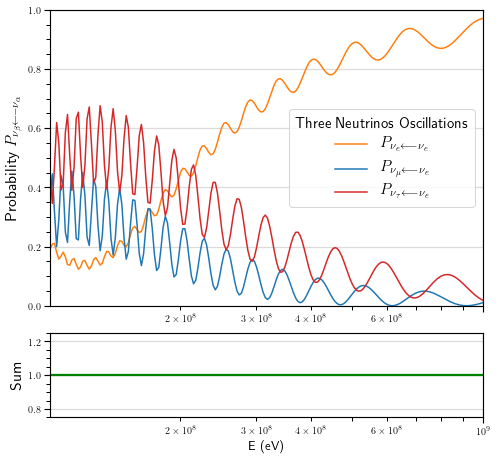

In [11]:
folder_name = "Osc3Neutrinos"
plot_name = "Osc3VacuumEnergy"
x_label = "E (eV)"
plot_probs(folder_name, plot_name, E_vals, prob_vac_eng, x_label, size=(7, 6.5), al=1)

## Oscillations in Matter with Constant Density

#### Fixed Energies and varying Distances

In [12]:
def osc3neutrinos_matter_baseline(L_min, L_max, nbpoints=1000, E=1e7):
    """Compute the Three neutrinos oscillations for varying
    values of distances in a matter with constant density.
    
    Parameters:
    ----------
    L_min: float
        Minimal value of the baseline
    L_max: float
        Maximal value of the baseline
    nbpoints: int, optional
        Number of points between L_min and L_max
    E: float, optional
        Value of the energy
    """
    L_vals = np.linspace(L_min, L_max, num=nbpoints)
    H_vac = hamiltonians3nu.hamiltonian_3nu_vacuum_energy_independent(
                S12_NO_BF, S23_NO_BF,
                S13_NO_BF, DCP_NO_BF,
                D21_NO_BF, D31_NO_BF
            )
    H_mat = hamiltonians3nu.hamiltonian_3nu_matter(
                H_vac,
                E,
                VCC_EARTH_CRUST
            )
    probs = [oscprob3nu.probabilities_3nu(
                H_mat,
                l * CONV_KM_TO_INV_EV
            ) for l in L_vals]
    return L_vals, np.array(probs)

In [13]:
L_vals, prob_mat_dist = osc3neutrinos_matter_baseline(lmin, lmax)

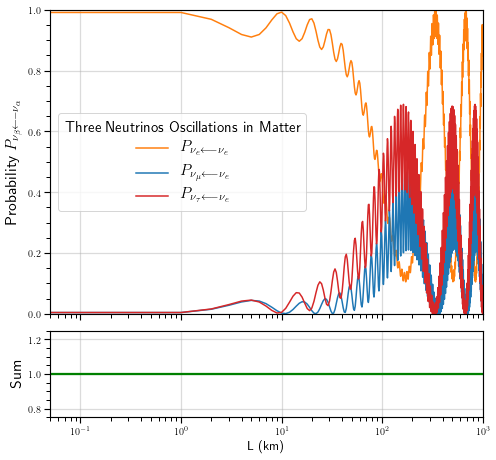

In [14]:
folder_name = "Osc3Neutrinos"
plot_name = "Osc3MatterBaseline"
x_label = "L (km)"
titl = "Three Neutrinos Oscillations in Matter"
plot_probs(folder_name, plot_name, L_vals, prob_mat_dist, x_label, size=(7, 6.5), titl=titl)

#### Varying Energies and Fixed Distances

In [15]:
def osc3neutrinos_matter_energy(E_min, E_max, nbpoints=200, L=2e3):
    """Compute the Three neutrinos oscillations for varying
    values of energies.
    
    Parameters:
    ----------
    E_min: float
        Minimal value of the energy (eV)
    E_max: float
        Maximal value of the energy  (eV)
    nbpoints: int, optional
        Number of points between E_min and E_max
    L: float, optional
        Value of the distance
    """
    E_vals = np.logspace(E_min, E_max, num=nbpoints)
    H_vac = hamiltonians3nu.hamiltonian_3nu_vacuum_energy_independent(
                S12_NO_BF, S23_NO_BF,
                S13_NO_BF, DCP_NO_BF,
                D21_NO_BF, D31_NO_BF
            )
    probs = [oscprob3nu.probabilities_3nu(
                hamiltonians3nu.hamiltonian_3nu_matter(
                H_vac,
                e,
                VCC_EARTH_CRUST
            ), L * CONV_KM_TO_INV_EV
            ) for e in E_vals]
    return E_vals, np.array(probs)

In [16]:
E_vals, prob_mat_eng = osc3neutrinos_matter_energy(emin, emax)

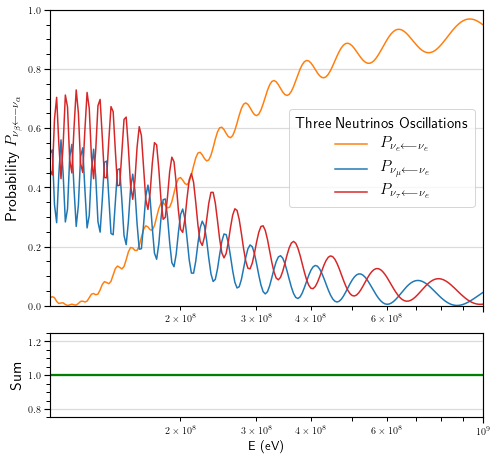

In [17]:
folder_name = "Osc3Neutrinos"
plot_name = "Osc3MatterEnergy"
x_label = "E (eV)"
titl = "Three Neutrinos Oscillations in Matter"
plot_probs(folder_name, plot_name, E_vals, prob_mat_eng, x_label, size=(7, 6.5), al=1)

## Comparison Vaccum Vs. Matter

In [18]:
def plot_combs(folder, name, xval, vacc, matt, x_label, size=(7, 6.5), al=1):
    # Create folder if non-existing
    if not os.path.exists("plots/{}".format(folder)):
        os.mkdir("plots/{}".format(folder))
    else:
        pass
    # Compute Difference
    diff = (vacc[:,0] - matt[:,1]) + matt[:,2]
    fig = plt.figure(figsize=size)
    gs  = gridspec.GridSpec(2, 1, height_ratios=[3.5, 1])

    ## Upper panel ##
    ax0 = plt.subplot(gs[0])
    # Pem
    ax0.plot(xval, vacc[:,1], color=Category10[4][0], label="Vacuum")
    ax0.plot(xval, matt[:,1], color=Category10[4][3], label="Matter")
    ax0.set_xscale('log')

    # Tick params
    axes_width(ax0, lw=1.15)
    ax0.tick_params(length=6, width=1.15, labelbottom=False)
    ax0.tick_params(which='minor', length=4, width=1)
    # y-axis
    ax0.yaxis.set_minor_locator(MultipleLocator(.05))
    ax0.grid(alpha=.45, linewidth=1.25)
    # Axes limit
    ax0.set_ylim(0, np.max(vacc[:,1]) + 0.025)
    ax0.set_xlim(xval[0] + 0.05, xval[-1])
    # Legend
    ax0.legend(title="Vacuum vs. Matter with Constant Densisty",
               title_fontsize=15, fontsize=16, ncol=1, fancybox=True)
    ax0.set_ylabel(r"Probability $P_{\nu_\mu \longleftarrow \nu_e}$", fontsize=16)

    # Lower panel
    ax1 = plt.subplot(gs[1])
    ax1.plot(xval, diff, color="green", linewidth=2.25)
    ax1.set_xscale('log')
    
    # Tick params
    axes_width(ax1, lw=1.15)
    ax1.tick_params(length=6, width=1.15)
    ax1.tick_params(which='minor', length=4, width=1)
    # y-axis
    ax1.yaxis.set_major_locator(MultipleLocator(.2))
    ax1.yaxis.set_minor_locator(MultipleLocator(.05))
    ax1.grid(alpha=.45, linewidth=1.25)
    # Axes limit
    ax1.set_ylim(np.min(diff), 1.25)
    ax1.set_xlim(xval[0] + 0.05, xval[-1])
    ax1.set_ylabel("Relative Diff.", fontsize=16)
    # Label
    ax1.set_xlabel(x_label,fontsize=13)

    plt.tight_layout()
    plt.savefig('plots/{}/{}.pdf'.format(folder,name), dpi=175)

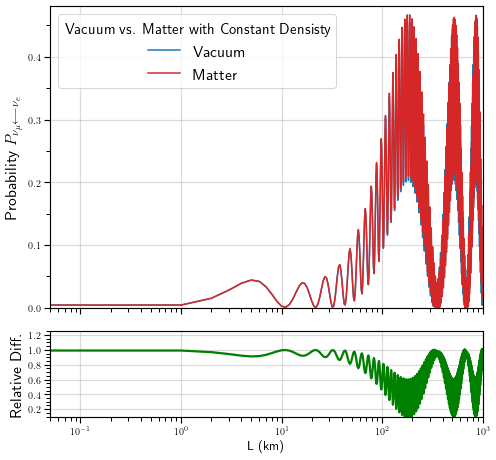

In [19]:
folder_name = "Osc3Neutrinos"
plot_name = "DistVacMatt"
x_label = "L (km)"
plot_combs(folder_name, plot_name, L_vals, prob_vac_dist, prob_mat_dist, x_label)

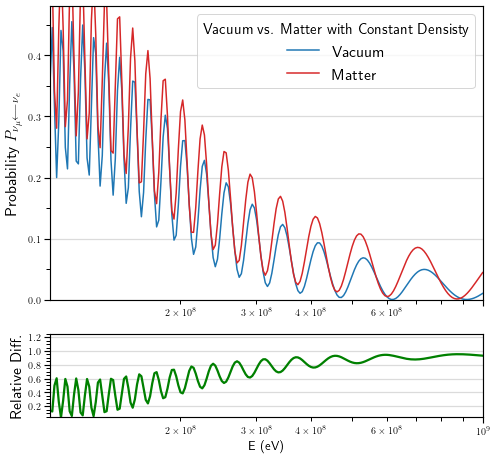

In [20]:
folder_name = "Osc3Neutrinos"
plot_name = "EngVacMatt"
x_label = "E (eV)"
plot_combs(folder_name, plot_name, E_vals, prob_vac_eng, prob_mat_eng, x_label)